In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
import prd_pipeline

## set up azure experiment


In [5]:
import azureml.core
from azureml.core import Workspace, Datastore, Dataset, Environment
from azureml.core import Experiment, ComputeTarget, ScriptRunConfig

In [6]:
prd_ws = Workspace.from_config()

In [7]:
azure_dataset_name ='sd3'
azure_experiment_name='prd_mlops_test'
azure_env_name = 'prd_ml_cluster'
cluster_name = 'mlops-test'

In [8]:
prd_model_name = 'azml_cluster_demo_20220414'

In [9]:
target_parameter = 'rainfall_rate_composite'
profile_features = ['air_temperature', 'relative_humidity']
single_lvl_features = ['air_pressure_at_sea_level'] 

In [10]:
prd_exp = Experiment(workspace=prd_ws, name=azure_experiment_name)
prd_exp

Name,Workspace,Report Page,Docs Page
prd_mlops_test,precip_rediagnosis,Link to Azure Machine Learning studio,Link to Documentation


Get the AzML environment (basically a conda environment) from the workspace.

In [11]:
prd_env = Environment.get(workspace=prd_ws, name=azure_env_name)
prd_env

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "azureml/openmpi3.1.2-cuda10.2-cudnn8-ubuntu18.04",
        "baseImageRegistry": {
            "address": "mcr.microsoft.com",
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {},
    "inferencingStackVersion": null,
    "name": "prd_ml_cluster",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "conda-forge"
            ],
            "dependencies": [
                "python=3.8",

### Load data

load the data from the script so we'renot duplicating code

In [12]:
# import importlib 
# importlib.reload(prd_cluster_train_demo)

In [13]:
input_data = prd_pipeline.load_data(
    prd_ws,
    dataset_name=azure_dataset_name
)
data_splits, data_dims = prd_pipeline.preprocess_data(
    input_data,
    feature_dict={'profile': profile_features, 'single_level': single_lvl_features,'target': target_parameter,},
    test_fraction=0.2, 
    test_savefn='tmp.csv'
)


{'profile': ['air_temperature', 'relative_humidity'], 'single_level': ['air_pressure_at_sea_level'], 'target': 'rainfall_rate_composite'}


In [14]:
# these are example calls to the code for easier debugging than running on a separate cluster
# model = prd_cluster_train_demo.build_model(**data_dims)
# model = prd_cluster_train_demo.train_model(model, data_splits)

In [15]:
import datetime
log_dir = 'log/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

### Execute our training run on a cluster

In [16]:
prd_demo_compute_target = ComputeTarget(workspace=prd_ws, name=cluster_name)
prd_demo_compute_target

AmlCompute(workspace=Workspace.create(name='precip_rediagnosis', subscription_id='07efdc52-cd27-48ed-9443-3aad2b6b777b', resource_group='precip_rediagnosis'), name=mlops-test, id=/subscriptions/07efdc52-cd27-48ed-9443-3aad2b6b777b/resourceGroups/precip_rediagnosis/providers/Microsoft.MachineLearningServices/workspaces/precip_rediagnosis/computes/mlops-test, type=AmlCompute, provisioning_state=Succeeded, location=uksouth, tags={})

In [17]:
prd_demo_args = ['--dataset-name', azure_dataset_name,
                 '--target-parameter', target_parameter,
                 '--model-name', prd_model_name,
                ]

prd_demo_args += ['--profile-features']
prd_demo_args += profile_features
prd_demo_args += ['--single-level_features']
prd_demo_args += single_lvl_features
prd_demo_args += ['--epochs', 10]
prd_demo_args += ['--batch-size', 128]
prd_demo_args += ['--learning-rate', 0.01]

prd_demo_args

['--dataset-name',
 'sd3',
 '--target-parameter',
 'rainfall_rate_composite',
 '--model-name',
 'azml_cluster_demo_20220414',
 '--profile-features',
 'air_temperature',
 'relative_humidity',
 '--single-level_features',
 'air_pressure_at_sea_level',
 '--epochs',
 10,
 '--batch-size',
 128,
 '--learning-rate',
 0.01]

In [18]:
prd_run_src = ScriptRunConfig(source_directory=os.getcwd(),
                      script='prd_cluster_train_demo.py',
                      arguments=prd_demo_args,
                      compute_target=prd_demo_compute_target,
                      environment=prd_env)

In [19]:
prd_run = prd_exp.submit(prd_run_src)
prd_run

Submitting /mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml/code/Users/hannah.brown/precip_rediagnosis/model_pipeline directory for run. The size of the directory >= 25 MB, so it can take a few minutes.


Experiment,Id,Type,Status,Details Page,Docs Page
prd_mlops_test,prd_mlops_test_1653664694_136dad7e,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [20]:
prd_run.wait_for_completion()
assert(prd_run.get_status() == "Completed")

## Evaluation

We now get the trained model to do some evaluatiion and create some plots

In [21]:
import tempfile

In [22]:
import tensorflow.keras

We download the model file into a temproary directory (so as not to pollute the local workspace) and load into memory to do inference

In [23]:
with tempfile.TemporaryDirectory() as td1:
    td_path = pathlib.Path(td1)
    prd_run.download_files(prefix=prd_model_name, output_directory=td1)
    model_path = td_path / prd_model_name
    list(model_path.iterdir())
    trained_model = tensorflow.keras.models.load_model(model_path)

In [24]:
trained_model

In [25]:
data_splits.keys()

dict_keys(['X_train', 'X_val', 'y_train', 'y_val'])

In [27]:
y_pred = trained_model.predict(data_splits['X_val'])

Text(0, 0.5, 'Predicted 3hr precip_accumulation value')

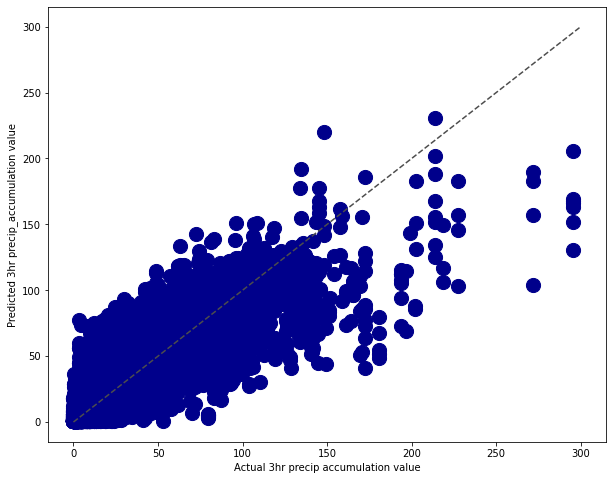

In [29]:
fig1 = plt.figure(figsize=(10, 8))
ax1 = fig1.add_subplot(1,1,1)
ax1.scatter(data_splits['y_val'], y_pred, s=200, c='darkblue')
ax1.plot([0, 300], [0, 300], ls="--", c=".3")
ax1.set_xlabel('Actual 3hr precip accumulation value')
ax1.set_ylabel('Predicted 3hr precip_accumulation value')

In [30]:
prd_run.log_image(name='actual_vs_pred', plot=fig1, description='predicted vs actual 3hr accumulations of rainfall')

In [31]:
prd_run.complete()